# Analyse complète : Séismes & Prix Immobiliers aux États-Unis  
Ce notebook regroupe :
- Deux cartes US (séismes & prix immobiliers)
- Un scatter avec régression
- Une analyse High/Low n_earthquake groupée
- Une visualisation centrée (taille de points)

In [119]:

import pandas as pd
import numpy as np
import altair as alt
from vega_datasets import data

# ---------------------------
# LOAD DATA
# ---------------------------
agg_county_year = pd.read_parquet("data/agg_county_year.parquet")
agg_state_year = pd.read_parquet("data/agg_state_year.parquet")
df_county_AC = pd.read_parquet("data/df_county_AC.parquet")
df_county_AK = df_county_AC[df_county_AC["state"].isin(["Alaska"])].copy()
df_county_CA = df_county_AC[df_county_AC["state"].isin(["California"])].copy()
df_county_NJ_W = pd.read_parquet("data/df_county_NJ_W.parquet")
df_county_NJ = df_county_NJ_W[df_county_NJ_W["state"].isin(["New Jersey"])].copy()
df_county_WY = df_county_NJ_W[df_county_NJ_W["state"].isin(["Wyoming"])].copy()
df_state_AC = pd.read_parquet("data/df_state_AC.parquet")
df_state_NJ_W = pd.read_parquet("data/df_state_NJ_W.parquet")

# Charger les données géographiques des États-Unis
counties = alt.topo_feature(data.us_10m.url, 'counties')
states = alt.topo_feature(data.us_10m.url, 'states')

# ---------------------------
# CONCAT
# ---------------------------
df_state_ACNJW = pd.concat([df_state_AC, df_state_NJ_W], ignore_index=True)
df_county_ACNJW = pd.concat([df_county_AC, df_county_NJ_W], ignore_index=True)

# ---------------------------
# FIPS CLEANING
# ---------------------------
for df in [df_county_AC, df_county_NJ_W, df_county_ACNJW, df_county_AK, df_county_CA, df_county_WY, df_county_NJ]:
    df["county_fips"] = (
        df["county_fips"]
        .astype(str)
        .str.replace(".0", "", regex=False)
        .str.zfill(5)
        .astype(int)   # for lookup
    )

# ---------------------------
# Fill NaN ONLY in numeric columns
# ---------------------------
for df in [agg_county_year, agg_state_year]:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)

### Chargement données pour la carte

In [120]:
from vega_datasets import data
# ---------------------------
# LOAD US STATES TOPOJSON
# ---------------------------
us_states = alt.topo_feature(data.us_10m.url, "states")

# ---------------------------
# FIPS TO INT
# ---------------------------
agg_state_year['state_fips'] = agg_state_year['state_fips'].astype(int)
agg_county_year['state_fips'] = agg_county_year['state_fips'].astype(int)
agg_county_year['county_fips'] = agg_county_year['county_fips'].astype(str).str.zfill(5)  # garde pour counties

# agg_county_year
# agg_state_year

## Sélection de l’année

In [121]:
year = 2015
agg_state_year_chosen = agg_state_year[agg_state_year["year"] == year]
agg_county_year_chosen = agg_county_year[agg_county_year["year"] == year]

# print(agg_state_year_chosen.head(), df_county_aggreg_year.head())

# Carte US : Intensité des Séismes et Prix Médian des Maisons

In [122]:
agg_state_year_eq = agg_state_year['n_earthquakes'].dropna()

# Créer une échelle log avec un domaine cohérent
log_scale = alt.Scale(
    type="log",
    domain=[max(1, agg_state_year_eq.min()), agg_state_year_eq.max()],  # Commence à 1 pour log
    range=["#ffe6e6", "#800000"],  # Garder les mêmes couleurs
    clamp=True  # Pour éviter les valeurs hors domaine
)
heatmap_year_eq = alt.Chart(us_states).mark_geoshape().encode(
    color=alt.Color("n_earthquakes:Q",
        scale=log_scale,  # ÉCHELLE LOG
        title="Number of Earthquakes (log)"),
    tooltip=["state:N", "n_earthquakes:Q"]
).transform_lookup(
    lookup="id",
    from_=alt.LookupData(agg_state_year.dropna(subset=["n_earthquakes"]), "state_fips", ["n_earthquakes", "state"])
).project("albersUsa").properties(
    title="USA Earthquakes Map (by state and by county)", width=400, height=320
)

heatmap_year_price = alt.Chart(us_states).mark_geoshape().encode(
    color=alt.Color(
        "avg_price:Q",
        scale=alt.Scale(range=["#e6f2ff", "#0055aa"]),
        title="Average real estate price ($)"
    ),
    tooltip=["state:N", "avg_price:Q"]
).transform_lookup(
    lookup="id",
    from_=alt.LookupData(agg_state_year.dropna(subset=["avg_price"]), "state_fips", ["avg_price", "state"])
).project("albersUsa").properties(
    title="USA Average real estate price (by state and by county)", width=400, height=320
)

In [123]:
# --------------------------------------------------------
# UNIFIED SIZE COUNTY MAPS — INDIVIDUAL PROJECTIONS
# --------------------------------------------------------
# For each state, use a custom center + scale so all appear same size.

projection_params = {
    "AK": {"center": [-180, 72], "scale": 200},
    "CA": {"center": [-119.5, 37]},
    "WY": {"center": [-107.5, 43]},
    "NJ": {"center": [-74.6, 40.1]},
}
all_data = pd.concat([
    df_county_AK['n_earthquakes'].dropna(),
    df_county_CA['n_earthquakes'].dropna(),
    df_county_WY['n_earthquakes'].dropna(),
    df_county_NJ['n_earthquakes'].dropna()
])
# Créer une échelle log avec un domaine cohérent
log_scale = alt.Scale(
    type="log",
    domain=[max(1, all_data.min()), all_data.max()],  # Commence à 1 pour log
    range=["#ffe6e6", "#800000"],  # Garder les mêmes couleurs
    clamp=True  # Pour éviter les valeurs hors domaine
)

# ALASKA
map_county_eq_AK = (
    alt.Chart(counties)
    .mark_geoshape(stroke="white", strokeWidth=0.25, clip=True)
    .encode(
        color=alt.Color("n_earthquakes:Q",
                        scale=log_scale,  # ÉCHELLE LOG
                        title="Number of Earthquakes (log)"),
        tooltip=["state:N", "county:N", 
                 alt.Tooltip("n_earthquakes:Q", format=",.0f", title="Earthquakes")]
    )
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(df_county_AK.dropna(subset=["n_earthquakes"]),
                             "county_fips",
                             ["n_earthquakes", "county", "state"])
    )
    .project(type="mercator",
             center=projection_params["AK"]["center"],
             scale=projection_params["AK"]["scale"])
    .properties(width=200, height=160, title="Alaska")
)

# CALIFORNIA
map_county_eq_CA = (
    alt.Chart(counties)
    .mark_geoshape(stroke="white", strokeWidth=0.25, clip=True)
    .encode(
        color=alt.Color("n_earthquakes:Q",
                        scale=log_scale,  # Même échelle log pour tous
                        title="Number of Earthquakes (log)"),
        tooltip=["state:N", "county:N", 
                 alt.Tooltip("n_earthquakes:Q", format=",.0f", title="Earthquakes")]
    )
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(df_county_CA.dropna(subset=["n_earthquakes"]),
                             "county_fips",
                             ["n_earthquakes", "county", "state"])
    )
    .project(type="mercator",
             center=projection_params["CA"]["center"])
    .properties(width=200, height=160, title="California")
)

# WYOMING
map_county_eq_WY = (
    alt.Chart(counties)
    .mark_geoshape(stroke="white", strokeWidth=0.25, clip=True)
    .encode(
        color=alt.Color("n_earthquakes:Q",
                        scale=log_scale,  # Même échelle log pour tous
                        title="Number of Earthquakes (log)"),
        tooltip=["state:N", "county:N", 
                 alt.Tooltip("n_earthquakes:Q", format=",.0f", title="Earthquakes")]
    )
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(df_county_WY.dropna(subset=["n_earthquakes"]),
                             "county_fips",
                             ["n_earthquakes", "county", "state"])
    )
    .project(type="mercator",
             center=projection_params["WY"]["center"])
    .properties(width=200, height=160, title="Wyoming")
)

# NEW JERSEY
map_county_eq_NJ = (
    alt.Chart(counties)
    .mark_geoshape(stroke="white", strokeWidth=0.25, clip=True)
    .encode(
        color=alt.Color("n_earthquakes:Q",
                        scale=log_scale,  # Même échelle log pour tous
                        title="Number of Earthquakes (log)"),
        tooltip=["state:N", "county:N", 
                 alt.Tooltip("n_earthquakes:Q", format=",.0f", title="Earthquakes")]
    )
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(df_county_NJ.dropna(subset=["n_earthquakes"]),
                             "county_fips",
                             ["n_earthquakes", "county", "state"])
    )
    .project(type="mercator",
             center=projection_params["NJ"]["center"])
    .properties(width=200, height=160, title="New Jersey")
)

# Combiner les cartes
county_eq_maps = ((map_county_eq_CA | map_county_eq_AK) &
              (map_county_eq_WY | map_county_eq_NJ))

# # Ajouter une configuration pour la légende
# county_eq_maps = county_eq_maps.configure_legend(
#     titleFontSize=12,
#     labelFontSize=10,
#     gradientLength=300,
#     gradientThickness=20
# ).properties(
#     title="Earthquake Distribution by County (Logarithmic Scale)"
# )

# county_eq_maps

In [124]:

# --------------------------------------------------------
# UNIFIED SIZE COUNTY MAPS — INDIVIDUAL PROJECTIONS
# --------------------------------------------------------
# For each state, use a custom center + scale so all appear same size.

projection_params = {
    "AK": {"center": [-180, 72], "scale": 200},
    "CA": {"center": [-119.5, 37]},
    "WY": {"center": [-107.5, 43]},
    "NJ": {"center": [-74.6, 40.1]},
}

# ALASKA
map_county_re_AK = (
    alt.Chart(counties)
    .mark_geoshape(stroke="white", strokeWidth=0.25, clip=True)  # ADD clip=True HERE
    .encode(
        color=alt.Color("avg_price:Q",
                        scale=alt.Scale(range=["#e6f2ff", "#0055aa"]),
                        title="Average real estate price ($)"),
        tooltip=["state:N", "county:N", "avg_price:Q"]
    )
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(df_county_AK.dropna(subset=["avg_price"]),
                             "county_fips",
                             ["avg_price", "county", "state"])
    )
    .project(type="mercator",
             center=projection_params["AK"]["center"],
             scale=projection_params["AK"]["scale"])
    .properties(width=200, height=160, title="Alaska")
)

# CALIFORNIA
map_county_re_CA = (
    alt.Chart(counties)
    .mark_geoshape(stroke="white", strokeWidth=0.25, clip=True)  # ADD clip=True HERE
    .encode(
        color=alt.Color("avg_price:Q",
                        scale=alt.Scale(range=["#e6f2ff", "#0055aa"]),
                        title="Average real estate price ($)"),
        tooltip=["state:N", "county:N", "avg_price:Q"]
    )
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(df_county_CA.dropna(subset=["avg_price"]),
                             "county_fips",
                             ["avg_price", "county", "state"])
    )
    .project(type="mercator",
             center=projection_params["CA"]["center"])
    .properties(width=200, height=160, title="California")
)

# WYOMING
map_county_re_WY = (
    alt.Chart(counties)
    .mark_geoshape(stroke="white", strokeWidth=0.25, clip=True)  # ADD clip=True HERE
    .encode(
        color=alt.Color("avg_price:Q",
                        scale=alt.Scale(range=["#e6f2ff", "#0055aa"]),
                        title="Average real estate price ($)"),
        tooltip=["state:N", "county:N", "avg_price:Q"]
    )
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(df_county_WY.dropna(subset=["avg_price"]),
                             "county_fips",
                             ["avg_price", "county", "state"])
    )
    .project(type="mercator",
             center=projection_params["WY"]["center"])
    .properties(width=200, height=160, title="Wyoming")
)

# NEW JERSEY
map_county_re_NJ = (
    alt.Chart(counties)
    .mark_geoshape(stroke="white", strokeWidth=0.25, clip=True)  # ADD clip=True HERE
    .encode(
        color=alt.Color("avg_price:Q",
                        scale=alt.Scale(range=["#e6f2ff", "#0055aa"]),
                        title="Average real estate price ($)"),
        tooltip=["state:N", "county:N", "avg_price:Q"]
    )
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(df_county_NJ.dropna(subset=["avg_price"]),
                             "county_fips",
                             ["avg_price", "county", "state"])
    )
    .project(type="mercator",
             center=projection_params["NJ"]["center"])
    .properties(width=200, height=160, title="New Jersey")
)

# Combiner les cartes - NOTE: use | for horizontal and & for vertical
county_re_maps = ((map_county_re_CA | map_county_re_AK) &
              (map_county_re_WY | map_county_re_NJ))

county_re_maps

alt.VConcatChart(...)

In [125]:
# ---------------------------
# Combine side-by-side 2x2
# ---------------------------
(heatmap_year_eq | heatmap_year_price).resolve_scale(color="independent") & (county_eq_maps | county_re_maps).resolve_scale(color="independent")


alt.VConcatChart(...)

# Corrélation Séismes ↔ Prix

## 🔎 Analyse de la Relation entre l’Activité Sismique et les Prix Immobiliers  
### Une visualisation combinant échelle logarithmique, intensité sismique et tendance générale

Cette visualisation explore comment le nombre de séismes dans un État américain est associé au prix médian de l’immobilier.  
Elle combine plusieurs éléments complémentaires :

- **Scatter plot** : chaque point représente un État pour l’année sélectionnée.  
- **Échelle logarithmique sur l’axe des X** : permet de visualiser correctement des niveaux de sismicité très différents (de 1 à plusieurs centaines).  
- **Couleur continue (Viridis)** : encode l’intensité des séismes, renforçant la lecture des variations.  
- **Regression Linéaire** : une tendance linéaire qui met en évidence la relation générale.  

L’objectif final est d’offrir une lecture claire, équilibrée et robuste de la relation potentielle entre l’activité sismique et les prix domiciliaires, malgré la grande variabilité des États.

In [126]:
# Filter out invalid values
df_corr = agg_state_year_chosen[
    (agg_state_year_chosen["n_earthquakes"] > 0) &
    (agg_state_year_chosen["avg_price"] > 0)
].copy()

# Ensure numeric
df_corr["n_earthquakes"] = pd.to_numeric(df_corr["n_earthquakes"], errors="coerce")
df_corr["avg_price"] = pd.to_numeric(df_corr["avg_price"], errors="coerce")

# Color scale
color_scale = alt.Scale(type="log", scheme="viridis")

scatter = (
    alt.Chart(df_corr)
    .mark_circle(size=90, opacity=0.75)
    .encode(
        x=alt.X("n_earthquakes:Q", title="Earthquakes (log scale)", scale=alt.Scale(type="log")),
        y=alt.Y("avg_price:Q", title="Average House Price ($)", scale=alt.Scale(zero=False)),
        color=alt.Color("n_earthquakes:Q", title="Earthquake Count", scale=color_scale,
                        legend=alt.Legend(labelExpr="datum.label")),
        tooltip=[
            alt.Tooltip("state:N"),
            alt.Tooltip("n_earthquakes:Q", title="Earthquakes"),
            alt.Tooltip("avg_price:Q", title="Avg Price ($)")
        ]
    )
)

smooth = (
    alt.Chart(df_corr)
    .transform_regression("n_earthquakes", "avg_price", method="linear")
    .mark_line(color="black", size=3)
    .encode(
        x=alt.X("n_earthquakes:Q", scale=alt.Scale(type="log")),
        y="avg_price:Q"
    )
)

correlation = (scatter + smooth).properties(
    width=900,
    height=550,
    title="Earthquake Frequency vs House Prices (Log Scale)"
)

correlation

alt.LayerChart(...)

In [127]:
import altair as alt
import pandas as pd
import numpy as np

# --------------------------
# 1. FILTER AND CLEAN DATA
# --------------------------

df_corr = agg_state_year_chosen[
    (agg_state_year_chosen["n_earthquakes"] > 0) &
    (agg_state_year_chosen["avg_price"] > 0) &
    (agg_state_year_chosen["avg_magnitude"].notna())
].copy()

# Ensure numeric
df_corr["n_earthquakes"] = pd.to_numeric(df_corr["n_earthquakes"], errors="coerce")
df_corr["avg_price"] = pd.to_numeric(df_corr["avg_price"], errors="coerce")
df_corr["avg_magnitude"] = pd.to_numeric(df_corr["avg_magnitude"], errors="coerce")

# --------------------------
# 2. CREATE DYNAMIC EXCLUSIVE BINS
# --------------------------

# Determine min and max for avg_magnitude
min_mag = df_corr["avg_magnitude"].min()
max_mag = df_corr["avg_magnitude"].max()

# Create 5 equal-width bins between min and max
bins = np.linspace(min_mag, max_mag, num=6)  # 6 edges → 5 bins
labels = [f"{round(bins[i],1)}-{round(bins[i+1],1)}" for i in range(len(bins)-1)]

# right=False ensures exclusive upper boundary
df_corr["magnitude_bin"] = pd.cut(df_corr["avg_magnitude"], bins=bins, labels=labels, right=False)

# --------------------------
# 3. DEFINE DARK COLOR SCALE
# --------------------------

color_scale = alt.Scale(
    domain=labels,
    range=["#7f3c8d", "#11a579", "#3969ac", "#f2b701", "#e73f74"]  # dark, distinct
)

# --------------------------
# 4. SCATTER PLOT
# --------------------------

scatter = (
    alt.Chart(df_corr)
    .mark_circle(size=90, opacity=0.75)
    .encode(
        x=alt.X("n_earthquakes:Q", title="Earthquakes (log scale)", scale=alt.Scale(type="log")),
        y=alt.Y("avg_price:Q", title="Average House Price ($)", scale=alt.Scale(zero=False)),
        color=alt.Color("magnitude_bin:N", title="Avg Magnitude Bin", scale=color_scale),
        tooltip=[
            alt.Tooltip("state:N"),
            alt.Tooltip("n_earthquakes:Q", title="Earthquakes"),
            alt.Tooltip("avg_price:Q", title="Avg Price ($)"),
            alt.Tooltip("avg_magnitude:Q", title="Avg Magnitude"),
            alt.Tooltip("magnitude_bin:N", title="Magnitude Bin")
        ]
    )
)

# --------------------------
# 5. REGRESSION TRENDLINE
# --------------------------

smooth = (
    alt.Chart(df_corr)
    .transform_regression("n_earthquakes", "avg_price", method="linear")
    .mark_line(color="black", size=3)
    .encode(
        x=alt.X("n_earthquakes:Q", scale=alt.Scale(type="log")),
        y="avg_price:Q"
    )
)

# --------------------------
# 6. COMBINE PLOT
# --------------------------

correlation = (scatter + smooth).properties(
    width=900,
    height=550,
    title="Earthquake Frequency vs House Prices (Log Scale, Dynamic Magnitude Bins)"
)

correlation


alt.LayerChart(...)

# Classification des États : High vs Low n_earthquake
Seuls les États dans les quantiles 20% et 80% sont conservés.

In [128]:
# Sum of earthquakes per state
state_totals = agg_state_year_chosen.groupby('state')['n_earthquakes'].sum().sort_values()

threshold_high = state_totals.quantile(0.8)
threshold_low = state_totals.quantile(0.2)

def classify_state(state):
    total = state_totals[state]
    if total >= threshold_high:
        return 'High n_earthquake'
    elif total <= threshold_low:
        return 'Low n_earthquake'
    else:
        return 'Medium'

# Apply classification
agg_state_year_chosen['quake_group'] = agg_state_year_chosen['state'].apply(classify_state)

# Select only high and low groups
df_selected = agg_state_year_chosen[agg_state_year_chosen['quake_group'].isin(['High n_earthquake', 'Low n_earthquake'])]

# df_selected.head()

/var/folders/lq/3djnzdbx6ll0000lzlm2th6w0000gn/T/ipykernel_67535/3017478637.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_state_year_chosen['quake_group'] = agg_state_year_chosen['state'].apply(classify_state)


# Evolution des prix selon High / Low n_earthquake

/var/folders/lq/3djnzdbx6ll0000lzlm2th6w0000gn/T/ipykernel_67535/3196783192.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0f}'.format(y).replace(",", " ") for y in ax.get_yticks()])


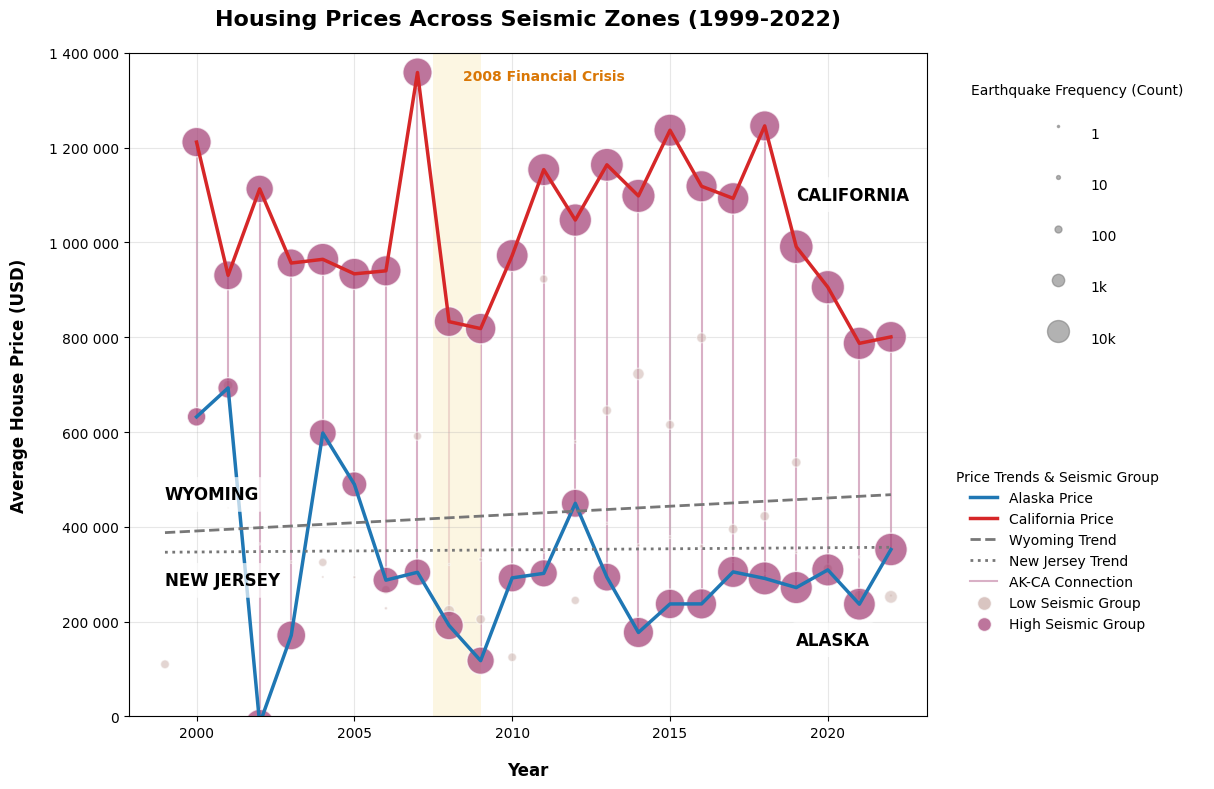

In [152]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# ---------------------------
# FILTRAGE ET PRÉPARATION (inchangé)
# ---------------------------
# NOTE: Le DataFrame agg_state_year doit être défini dans votre environnement.
# J'assume qu'il contient 'year', 'n_earthquakes', 'avg_price' et 'state'.

df_filtered_ACNJW = df_state_ACNJW[
    (df_state_ACNJW['year'] >= 1999) &
    (df_state_ACNJW['year'] <= 2022) &
    (df_state_ACNJW['avg_price'] >= 0)
].copy()

df_filtered_ACNJW['eq_size'] = np.sqrt(df_filtered_ACNJW['n_earthquakes'])

states_of_interest = ['Alaska', 'California', 'Wyoming', 'New Jersey']
df_filtered = df_filtered_ACNJW[df_filtered_ACNJW['state'].isin(states_of_interest)]
df_filtered = df_filtered.sort_values(['state', 'year']).reset_index(drop=True)

# Classification High vs Low Seismic
df_filtered['seismic_group'] = df_filtered['state'].apply(
    lambda x: 'High Seismic' if x in ['Alaska', 'California'] else 'Low Seismic'
)

# ---------------------------
# COULEURS
# ---------------------------
ALASKA_COLOR = '#1f77b4'
CALIFORNIA_COLOR = '#d62728'
OTHER_COLOR = '#777777'

EARTHQUAKE_COLORS = {
    'High Seismic': '#A23B72',
    'Low Seismic': '#C9ADA7'
}

# ---------------------------
# FIGURE
# ---------------------------
fig, ax = plt.subplots(figsize=(14, 8)) # Augmentation de la hauteur pour le titre et les labels

# ---------------------------
# ARRIÈRE-PLAN: tous les séismes
# ---------------------------
# Low Seismic
low_eq = df_filtered[df_filtered['seismic_group']=='Low Seismic']
# Stocker les handles pour la légende
handle_low_eq = ax.scatter(low_eq['year'], low_eq['avg_price'],
                           s=np.sqrt(low_eq['n_earthquakes'])*2,
                           color=EARTHQUAKE_COLORS['Low Seismic'],
                           alpha=0.5, edgecolors='w', zorder=2) # zorder pour mettre devant la zone de crise

# High Seismic
high_eq = df_filtered[df_filtered['seismic_group']=='High Seismic']
handle_high_eq = ax.scatter(high_eq['year'], high_eq['avg_price'],
                            s=np.sqrt(high_eq['n_earthquakes'])*2.5,
                            color=EARTHQUAKE_COLORS['High Seismic'],
                            alpha=0.7, edgecolors='w', zorder=2)

# ---------------------------
# LIGNES DE PRIX: Alaska et California
# ---------------------------
handles_lines = []
for state, color in zip(['Alaska','California'], [ALASKA_COLOR,CALIFORNIA_COLOR]):
    state_data = df_filtered[df_filtered['state']==state]
    line, = ax.plot(state_data['year'], state_data['avg_price'], color=color, lw=2.5, label=f"{state} Price")
    handles_lines.append(line)
    
    # Positionnement du label au 3/4 du chemin (index -6 sur 24 points de données)
    # Mise en valeur avec un fond blanc
    idx = -4
    ax.text(state_data['year'].values[idx], state_data['avg_price'].values[idx] + (-110000 if state == 'Alaska' else +110000), # + ou - pour décaler
            state.upper(), # Mise en majuscules pour accentuer
            color='black', fontsize=12, va='center', fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))


# ---------------------------
# REGRESSION WY et NJ
# ---------------------------
point_styles = {'Wyoming':'--','New Jersey':':'}
for state in ['Wyoming','New Jersey']:
    state_data = df_filtered[df_filtered['state']==state]
    X = state_data['year'].values.reshape(-1,1)
    y = state_data['avg_price'].values
    reg = LinearRegression().fit(X,y)
    y_pred = reg.predict(X)
    line, = ax.plot(state_data['year'], y_pred, color=OTHER_COLOR, lw=2,
            linestyle=point_styles[state], label=f"{state} Trend")
    handles_lines.append(line)
    idx = 0
    ax.text(state_data['year'].values[idx], y_pred[idx] + (-70000 if state == 'New Jersey' else +70000),
            state.upper(), # Mise en majuscules pour accentuer
            color='black', fontsize=12, va='baseline', fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

# ---------------------------
# CONNECT AK et CA
# ---------------------------
ak_data = df_filtered[df_filtered['state']=='Alaska']
ca_data = df_filtered[df_filtered['state']=='California']
# Utiliser une seule ligne pour la légende
line_connect, = ax.plot([], [], color=EARTHQUAKE_COLORS['High Seismic'], alpha=0.4, lw=1.5, label='AK-CA Connection')
handles_lines.append(line_connect)

# Tracer les lignes de connexion
for year in ak_data['year']:
    ak_price = ak_data[ak_data['year']==year]['avg_price'].values[0]
    ca_price = ca_data[ca_data['year']==year]['avg_price'].values[0]
    ax.plot([year, year], [ak_price, ca_price],
            color=EARTHQUAKE_COLORS['High Seismic'], alpha=0.4, lw=1.5, zorder=1) # zorder=1 pour être en dessous

# ---------------------------
# ZONE CRISE 2008 (au-dessus des connexions, en dessous des points)
# ---------------------------
ax.axvspan(2007.5, 2009, color="#FBF1CF", alpha=0.6, lw=0, zorder=1)
ax.text(2011, 1_550_000, "2008 Financial Crisis", color='#D97706', fontsize=10,
        fontweight='bold', ha='center', va='center', zorder=3)


# ---------------------------
# LÉGENDE TAILLE (séismes)
# ---------------------------
# Bulles
handles_sizes = []
size_legend_data = [1, 10, 100, 1000, 10000]
size_legend_labels = ['1','10','100','1k','10k']
for s,label in zip(size_legend_data,size_legend_labels):
    # Créer les handles de taille sans les labels
    handles_sizes.append(ax.scatter([], [], s=np.sqrt(s)*2.5, color='gray', alpha=0.6))
    
# Bulles de couleur pour les groupes (pour la clarté)
handle_low_eq_color = ax.scatter([], [], s=100, color=EARTHQUAKE_COLORS['Low Seismic'], alpha=0.7, edgecolors='w', label='Low Seismic Group')
handle_high_eq_color = ax.scatter([], [], s=100, color=EARTHQUAKE_COLORS['High Seismic'], alpha=0.7, edgecolors='w', label='High Seismic Group')
handles_eq_groups = [handle_low_eq_color, handle_high_eq_color]


# --- Construction de la légende complète ---
# Séparer la légende en deux sections (Tailles de bulles et Couleurs/Lignes)
# 1. Légende de taille
legend1 = ax.legend(handles=handles_sizes, labels=size_legend_labels,
                    loc='center left', bbox_to_anchor=(1.02, 0.75),
                    title='Earthquake Frequency (Count)', 
                    fontsize=10, handlelength=3, handleheight=3, 
                    borderpad=1.5, labelspacing=1.5, frameon=False)
# Ajouter cette légende au plot
ax.add_artist(legend1)

# 2. Légende des lignes et des groupes
legend2 = ax.legend(handles=handles_lines + handles_eq_groups,
                    loc='center left', bbox_to_anchor=(1.02, 0.25),
                    title='Price Trends & Seismic Group', 
                    fontsize=10, frameon=False)

# ---------------------------
# AXES + TITRE
# ---------------------------
# Mise en gras et plus d'espace pour les labels
ax.set_xlabel('Year', fontsize=12, fontweight='bold', labelpad=15)
ax.set_ylabel('Average House Price (USD)', fontsize=12, fontweight='bold', labelpad=15)

# Augmenter la marge Y pour un meilleur centrage des labels K
ax.ticklabel_format(style='plain', axis='y')
ax.set_yticklabels(['{:,.0f}'.format(y).replace(",", " ") for y in ax.get_yticks()])

ax.set_ylim(200_000, 1_600_000)
ax.grid(alpha=0.3)

# Mise en valeur du titre et écartement
ax.set_title('Housing Prices Across Seismic Zones (1999-2022)', 
             fontsize=16, fontweight='bold', pad=20)


plt.tight_layout(rect=[0, 0, 0.85, 1]) # Réserve de l'espace pour la double légende à droite
plt.show()

In [130]:
import altair as alt
import numpy as np

# --------------------------
# 1. CLEAN DATA
# --------------------------

df_corr = agg_state_year.copy()

# Remove invalid values
df_corr = df_corr[
    (df_corr["n_earthquakes"] > 0) &
    (df_corr["avg_price"] > 0)
].copy()

# Add log value for regression
df_corr["log_eq"] = np.log(df_corr["n_earthquakes"])

# --------------------------
# 2. SCATTER (log scale)
# --------------------------

color_scale = alt.Scale(scheme="viridis")

scatter_all = (
    alt.Chart(df_corr)
    .mark_circle(size=90, opacity=0.6)
    .encode(
        x=alt.X(
            "n_earthquakes:Q",
            title="Earthquakes (log scale)",
            scale=alt.Scale(type="log"),
            axis=alt.Axis(format="~s")
        ),
        y=alt.Y(
            "avg_price:Q",
            title="Median House Price ($)",
            scale=alt.Scale(zero=False, padding=10)
        ),
        color=alt.Color(
            "log_eq:Q",
            title="Earthquakes (log)",
            scale=color_scale
        ),
        tooltip=[
            alt.Tooltip("state:N", title="State"),
            alt.Tooltip("year:O", title="Year"),
            alt.Tooltip("n_earthquakes:Q", title="Earthquakes"),
            alt.Tooltip("avg_price:Q", title="House Price ($)")
        ]
    )
)

# --------------------------
# 3. TRENDLINE with log transform
# --------------------------

smooth_all = (
    alt.Chart(df_corr)
    .transform_regression(
        "log_eq", "avg_price"
    )
    .mark_line(
        color="black",
        size=3
    )
    .encode(
        x=alt.X(
            "n_earthquakes:Q",
            scale=alt.Scale(type="log")
        ),
        y="avg_price:Q"
    )
)

# --------------------------
# 4. COMBINE BOTH
# --------------------------

correlation_all = (
    (scatter_all + smooth_all)
    .properties(
        width=900,
        height=550,
        title="Relationship between Earthquake Frequency and House Prices (All Years, Log Scale)"
    )
    .configure_axis(
        gridOpacity=0.20,
        labelFontSize=12,
        titleFontSize=14
    )
    .configure_title(
        fontSize=22,
        anchor="start"
    )
)

correlation_all

alt.LayerChart(...)

In [131]:
import altair as alt
import numpy as np
import pandas as pd

# --------------------------
# 1. CLEAN DATA
# --------------------------

df_corr = agg_state_year.copy()

# Remove invalid values
df_corr = df_corr[
    (df_corr["n_earthquakes"] > 0) &
    (df_corr["avg_price"] > 0) &
    (df_corr["avg_magnitude"].notna())
].copy()

# Add log value for regression
df_corr["log_eq"] = np.log(df_corr["n_earthquakes"])

# --------------------------
# 2. CREATE DYNAMIC EXCLUSIVE BINS
# --------------------------

# Determine min and max of avg_magnitude
min_mag = df_corr["avg_magnitude"].min()
max_mag = df_corr["avg_magnitude"].max()

# Create 5 equal-width bins
bins = np.linspace(min_mag, max_mag, num=6)  # 6 edges → 5 bins
labels = [f"{round(bins[i],1)}-{round(bins[i+1],1)}" for i in range(len(bins)-1)]

# right=False ensures upper boundary is exclusive
df_corr["magnitude_bin"] = pd.cut(df_corr["avg_magnitude"], bins=bins, labels=labels, right=False)

# --------------------------
# 3. SCATTER WITH DARK COLORS
# --------------------------

color_scale = alt.Scale(
    domain=labels,
    range=["#7f3c8d", "#11a579", "#3969ac", "#f2b701", "#e73f74"]  # dark, distinct
)

scatter_all = (
    alt.Chart(df_corr)
    .mark_circle(size=90, opacity=0.7)
    .encode(
        x=alt.X(
            "n_earthquakes:Q",
            title="Earthquakes (log scale)",
            scale=alt.Scale(type="log"),
            axis=alt.Axis(format="~s")
        ),
        y=alt.Y(
            "avg_price:Q",
            title="Median House Price ($)",
            scale=alt.Scale(zero=False, padding=10)
        ),
        color=alt.Color(
            "magnitude_bin:N",
            title="Avg Magnitude Bin",
            scale=color_scale
        ),
        tooltip=[
            alt.Tooltip("state:N", title="State"),
            alt.Tooltip("year:O", title="Year"),
            alt.Tooltip("n_earthquakes:Q", title="Earthquakes"),
            alt.Tooltip("avg_price:Q", title="House Price ($)"),
            alt.Tooltip("avg_magnitude:Q", title="Avg Magnitude"),
            alt.Tooltip("magnitude_bin:N", title="Magnitude Bin")
        ]
    )
)

# --------------------------
# 4. TRENDLINE
# --------------------------

smooth_all = (
    alt.Chart(df_corr)
    .transform_regression("log_eq", "avg_price")
    .mark_line(color="black", size=3)
    .encode(
        x=alt.X("n_earthquakes:Q", scale=alt.Scale(type="log")),
        y="avg_price:Q"
    )
)

# --------------------------
# 5. COMBINE BOTH
# --------------------------

correlation_all = (
    (scatter_all + smooth_all)
    .properties(
        width=900,
        height=550,
        title="Earthquake Frequency vs House Prices (Dynamic Magnitude Bins)"
    )
    .configure_axis(
        gridOpacity=0.20,
        labelFontSize=12,
        titleFontSize=14
    )
    .configure_title(
        fontSize=22,
        anchor="start"
    )
    .configure_legend(
        titleFontSize=14,
        labelFontSize=13,
        symbolSize=150
    )
)

correlation_all



alt.LayerChart(...)

# Focus sur un Californie et Alaska

In [132]:
import altair as alt
import pandas as pd

# --- (Configuration des données et constantes) ---
states_of_interest = ["Alaska", "California", "Wyoming", "New Jersey"]

df = df_state_ACNJW[
    (df_state_ACNJW["state"].isin(states_of_interest)) &
    (df_state_ACNJW["year"] >= 1998) &
    (df_state_ACNJW["year"] <= 2022) &
    (df_state_ACNJW["n_earthquakes"] > 0) &
    (df_state_ACNJW["avg_price"] > 0)
].copy()

df["avg_price_million"] = df["avg_price"] / 1_000_000
df["state"] = pd.Categorical(df["state"], categories=states_of_interest, ordered=True)

RED = "#800000"
BLUE = "#0055aa"

crisis_line = alt.Chart(pd.DataFrame({"year":[2008]})).mark_rule(
    color="gray", strokeDash=[6,4], strokeWidth=2
).encode(x="year:O")

# ----------------------------------------------------
# 1. NEW FUNCTION: COMBINED MINI-PANEL BUILDER
# FIX: 'None' for format replaced with an empty string ('')
# ----------------------------------------------------
def make_consistent_panel(data, y_field, color, index, is_earthquake_panel=False):
    # Only show Y-axis labels for the first panel (index 0)
    show_labels = (index == 0)

    # CORRECTION : Utiliser '' au lieu de None pour le format par défaut.
    y_axis_format = '~s' if is_earthquake_panel else '' 

    base = alt.Chart(data).encode(
        x=alt.X("year:O",
                title=None,
                axis=alt.Axis(
                    values=list(range(1990, 2026, 5)),
                    labelAngle=0,
                    labelFontSize=11,
                    titleFontSize=12
                ))
    )
    line = base.mark_line(color=color, strokeWidth=3).encode(
        y=alt.Y(y_field,
                title=None,
                # Encodage de l'axe Y pour le partage d'échelle et le contrôle des labels
                axis=alt.Axis(
                    labels=show_labels, 
                    labelFontSize=11,
                    titleFontSize=12,
                    format=y_axis_format # Applique le format K ou le format par défaut ('')
                )
        )
    )
    trend = base.transform_regression("year", y_field).mark_line(
        color=color, strokeDash=[7,4], strokeWidth=2.5
    )
    return (line + trend + crisis_line).properties(width=220, height=150)

# ---------------------------
# 2. BUILD 4 PANELS FOR EARTHQUAKES
# ---------------------------
eq_panels_list = [
    make_consistent_panel(df[df["state"] == state], "n_earthquakes:Q", RED, i, is_earthquake_panel=True)
    for i, state in enumerate(states_of_interest)
]

eq_panels = alt.hconcat(
    *eq_panels_list,
    spacing=20
).resolve_scale(
    y="shared"
)

# ---------------------------
# 3. BUILD 4 PANELS FOR PRICES
# ---------------------------
pr_panels_list = [
    make_consistent_panel(df[df["state"] == state], "avg_price_million:Q", BLUE, i, is_earthquake_panel=False)
    for i, state in enumerate(states_of_interest)
]

pr_panels = alt.hconcat(
    *pr_panels_list,
    spacing=20
).resolve_scale(
    y="shared"
)

# ---------------------------
# STATE LABELS (Alignement parfait)
# ---------------------------
state_labels_charts = [
    alt.Chart().mark_text(text=state, fontSize=14, fontWeight="bold", align="center").encode(
        # Positionne le texte au milieu de la colonne de 220px
        x=alt.value(200) 
    ).properties(
        width=220, 
        height=20
    )
    for state in states_of_interest
]

state_labels = alt.hconcat(
    *state_labels_charts
)


# ---------------------------
# ROW HEADERS
# ---------------------------
eq_header = alt.Chart().mark_text(
    text="EARTHQUAKES",
    fontSize=14,
    fontWeight="bold",
    align="left",
    baseline="middle",
    dy=0
).properties(
    width=80,
    height=150
)

pr_header = alt.Chart().mark_text(
    text="AVERAGE HOME\nPRICE (M USD)",
    fontSize=14,
    fontWeight="bold",
    align="left",
    lineBreak='\n',
    baseline="middle",
    lineHeight=18,
    dy=-14
).properties(
    width=80,
    height=150
)

# ---------------------------
# ESPACES VIDES POUR ALIGNEMENT
# ---------------------------
empty_spacer = alt.Chart().mark_text(text="").properties(width=80, height=20)
x_spacer = alt.Chart().mark_text(text="").properties(width=80, height=30)

# ---------------------------
# AXE X GLOBAL
# ---------------------------
xlabel = alt.Chart().mark_text(
    text="Year", fontSize=14, fontWeight="bold"
).encode(x=alt.value(580) 
).properties(width=(220*4) + (20*3), height=30)

# ---------------------------
# LAYOUT FINAL (4×2)
# ---------------------------
eq_row_with_header = alt.hconcat(
    eq_header,
    eq_panels,
    spacing=15
)
pr_row_with_header = alt.hconcat(
    pr_header,
    pr_panels,
    spacing=15
)

state_labels_with_spacer = alt.hconcat(
    empty_spacer.properties(height=20),
    state_labels,
    spacing=15
)
xlabel_with_spacer = alt.hconcat(
    x_spacer.properties(height=30),
    xlabel,
    spacing=15
)

full_layout = alt.vconcat(
    state_labels_with_spacer,
    eq_row_with_header,
    pr_row_with_header,
    xlabel_with_spacer
).properties(
    title={
        "text": "Earthquakes and Home Prices (1999–2022)",
        "subtitle": "Red = earthquakes · Blue = home prices · Gray dashed line = 2008 crisis",
        "anchor": "middle",
        "fontSize": 22,
        "subtitleFontSize": 13
    },
    spacing=15
).configure_view(
    strokeWidth=0
)

full_layout

alt.VConcatChart(...)

# Dernière Visualisation

In [133]:
import altair as alt
import pandas as pd

# --- Filter data between 1999 and 2022 ---
df = df_state_AC[
    (df_state_AC['year'] >= 1999) &
    (df_state_AC['year'] <= 2022)
].copy()

df = df.dropna(subset=["avg_price", "n_earthquakes"])

# --- Compute normalization for earthquakes ---
ymin = df["avg_price"].min()
ymax = df["avg_price"].max()

df["eq_norm"] = (
    (df["n_earthquakes"] - df["n_earthquakes"].min()) /
    (df["n_earthquakes"].max() - df["n_earthquakes"].min())
) * (ymax - ymin) + ymin

# ------------------------------------
# AXIS DEFINITIONS
# ------------------------------------
left_axis = alt.Axis(title="Average House Price ($)")
right_axis = alt.Axis(title="Earthquakes (normalized)", orient="right")

# ------------------------------------
# SCATTER (left axis)
# ------------------------------------
scatter = (
    alt.Chart(df)
    .mark_circle(opacity=0.6)
    .encode(
        x=alt.X("year:O", title="Year"),
        y=alt.Y("avg_price:Q", axis=left_axis),
        size=alt.Size("n_earthquakes:Q",
                      title="Number of Earthquakes",
                      scale=alt.Scale(range=[50, 600])),
        color=alt.Color("state:N",
                        scale=alt.Scale(
                            domain=["Alaska", "California"],
                            range=["#1f77b4", "#d62728"]
                        )),
        tooltip=["state", "year", "avg_price", "n_earthquakes"]
    )
)

# ------------------------------------
# EARTHQUAKE REGRESSION (right axis)
# ------------------------------------
reg_right = (
    alt.Chart(df)
    .transform_regression("year", "eq_norm", groupby=["state"])
    .mark_line(size=3, strokeDash=[6,3])
    .encode(
        x="year:O",
        y=alt.Y("eq_norm:Q", axis=right_axis),
        color=alt.Color(
            "state:N",
            scale=alt.Scale(
                domain=["Alaska", "California"],
                range=["#1f77b4", "#d62728"]
            ),
            legend=None
        ),
        tooltip=["state", "year", "n_earthquakes"]
    )
)

# ------------------------------------
# PRICE LINE (left axis)
# ------------------------------------
price_line = (
    alt.Chart(df)
    .mark_line(size=3)
    .encode(
        x="year:O",
        y=alt.Y("avg_price:Q"),
        color=alt.Color(
            "state:N",
            scale=alt.Scale(
                domain=["Alaska", "California"],
                range=["#1f77b4", "#d62728"]
            ),
            title="States"
        )
    )
)

# ------------------------------------
# FINAL CHART
# ------------------------------------
chart = (
    (scatter + price_line + reg_right)
    .properties(
        width=900,
        height=500,
        title="Housing Prices vs Earthquake Trend (1999–2022)"
    )
    .configure_axis(labelFontSize=12, titleFontSize=14)
    .configure_title(fontSize=18, anchor="start")
)

chart

alt.LayerChart(...)

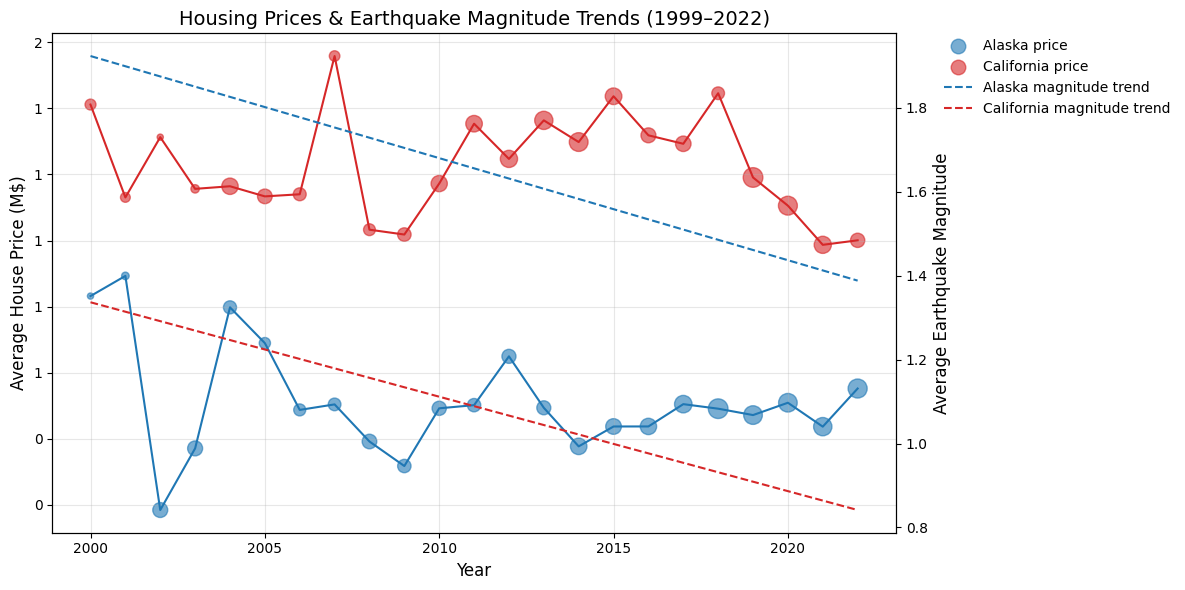

In [134]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter

# --- Filter data 1999-2022 ---
df = df_state_AC[(df_state_AC['year'] >= 1999) & (df_state_AC['year'] <= 2022)].copy()
df = df.dropna(subset=["avg_price", "n_earthquakes", "avg_magnitude"])

# --- Convert prices to millions ---
df['avg_price_million'] = df['avg_price'] / 1_000_000

# --- Separate states ---
df_alaska = df[df['state'] == 'Alaska']
df_california = df[df['state'] == 'California']

# --- Figure & axes ---
fig, ax_price = plt.subplots(figsize=(12,6))
ax_eq = ax_price.twinx()  # axe droit pour magnitude

# --- Scatter: avg_price vs year, size = n_earthquakes ---
max_marker = 200
min_marker = 20

for state_df, color in zip([df_alaska, df_california], ['#1f77b4', '#d62728']):
    sizes = min_marker + (state_df['n_earthquakes'] - state_df['n_earthquakes'].min()) / \
            (state_df['n_earthquakes'].max() - state_df['n_earthquakes'].min()) * (max_marker - min_marker)
    ax_price.scatter(
        state_df['year'],
        state_df['avg_price_million'],
        s=sizes,
        alpha=0.6,
        color=color,
        label=f"{state_df['state'].iloc[0]} price"
    )

# --- Lines: avg_price trends ---
for state_df, color in zip([df_alaska, df_california], ['#1f77b4', '#d62728']):
    ax_price.plot(
        state_df['year'],
        state_df['avg_price_million'],
        color=color,
        linewidth=1.5
    )

# --- Regression: avg_magnitude trend ---
for state_df, color in zip([df_alaska, df_california], ['#1f77b4', '#d62728']):
    X = state_df['year'].values.reshape(-1,1)
    y = state_df['avg_magnitude'].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    ax_eq.plot(
        state_df['year'],
        y_pred,
        color=color,
        linestyle='--',
        linewidth=1.5,
        label=f"{state_df['state'].iloc[0]} magnitude trend"
    )

# --- Axes labels ---
ax_price.set_ylabel("Average House Price (M$)", fontsize=12)
ax_eq.set_ylabel("Average Earthquake Magnitude", fontsize=12)
ax_price.set_xlabel("Year", fontsize=12)
ax_price.set_title("Housing Prices & Earthquake Magnitude Trends (1999–2022)", fontsize=14)

# --- Format Y axis (millions) ---
ax_price.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))

# --- Legends ---
lines, labels = ax_price.get_legend_handles_labels()
lines2, labels2 = ax_eq.get_legend_handles_labels()
all_lines = lines + lines2
all_labels = labels + labels2

ax_price.legend(
    all_lines,
    all_labels,
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0.,
    fontsize=10,
    frameon=False
)

# --- Grid & layout ---
ax_price.grid(alpha=0.3)
ax_price.tick_params(axis='both', which='major', labelsize=10)
ax_eq.tick_params(axis='y', labelsize=10)
fig.tight_layout()

plt.show()

In [135]:
import altair as alt
import pandas as pd
import numpy as np

# ============================================================
# PRÉPARATION DES DONNÉES
# ============================================================
# Filtrer les données pour Alaska et California
df = df_state_AC[
    (df_state_AC["state"].isin(["Alaska", "California"])) &
    (df_state_AC["year"] >= 1990) &
    (df_state_AC["n_earthquakes"] > 0) &
    (df_state_AC["avg_price"] > 0)
].copy()

# Trier par année pour une meilleure visualisation
df = df.sort_values(['state', 'year']).reset_index(drop=True)

# Créer des données pour les boîtes de statistiques
summary_stats = df.groupby('state').agg({
    'n_earthquakes': 'sum',
    'avg_price': 'mean'
}).reset_index()

summary_stats['n_earthquakes_formatted'] = summary_stats['n_earthquakes'].apply(
    lambda x: f"{x/1000:.0f}K" if x >= 1000 else f"{x:.0f}"
)
summary_stats['avg_price_formatted'] = summary_stats['avg_price'].apply(
    lambda x: f"${x/1000:.0f}K" if x < 1000000 else f"${x/1000000:.1f}M"
)

# Données pour les annotations (événements clés)
annotations_data = pd.DataFrame({
    'year': [1994, 1999, 2008, 2014, 2019],
    'event': ['Northridge\nEQ', 'Hector Mine\nEQ', 'Financial\nCrisis', 'Napa\nEQ', 'Ridgecrest\nEQ'],
    'type': ['EQ', 'EQ', 'Economic', 'EQ', 'EQ'],
    'y_pos': [0, 0, 0, 0, 0]
})

# ============================================================
# CONFIGURATION DES COULEURS
# ============================================================
color_scale = alt.Scale(
    domain=["Alaska", "California"],
    range=["#1f77b4", "#d62728"]
)

event_color_scale = alt.Scale(
    domain=['EQ', 'Economic'],
    range=['#ff7f0e', '#2ca02c']
)

# ============================================================
# 1. TIMELINE PRINCIPALE
# ============================================================
base = alt.Chart(df).properties(width=800, height=280)

# Lignes pour les prix
price_line = base.mark_line(strokeWidth=3, point=False).encode(
    x=alt.X('year:O', 
            title='Year',
            axis=alt.Axis(labelAngle=0, grid=False, labelFontSize=11)),
    y=alt.Y('avg_price:Q', 
            title='Average House Price ($)',
            scale=alt.Scale(zero=False),
            axis=alt.Axis(format='$,.0f', labelFontSize=11)),
    color=alt.Color('state:N', 
                    scale=color_scale,
                    legend=alt.Legend(title="State", 
                                     orient='top-right',
                                     titleFontSize=13,
                                     labelFontSize=12)),
    strokeDash=alt.condition(
        alt.datum.state == "Alaska",
        alt.value([5, 5]),
        alt.value([0])
    )
)

# Points pour les tremblements de terre (taille proportionnelle)
eq_points = base.mark_circle(opacity=0.7).encode(
    x='year:O',
    y='avg_price:Q',
    size=alt.Size('n_earthquakes:Q',
                  scale=alt.Scale(range=[50, 400], type='sqrt'),
                  title='Earthquakes/Year',
                  legend=alt.Legend(orient='top-right',
                                   titleFontSize=13,
                                   labelFontSize=12)),
    color=alt.Color('state:N', scale=color_scale, legend=None),
    tooltip=[
        alt.Tooltip('state:N', title='State'),
        alt.Tooltip('year:O', title='Year'),
        alt.Tooltip('n_earthquakes:Q', title='Earthquakes', format=','),
        alt.Tooltip('avg_price:Q', title='Avg Price', format='$,.0f')
    ]
)

# Lignes verticales pour les événements
event_rules = alt.Chart(annotations_data).mark_rule(
    strokeDash=[3, 3],
    strokeWidth=1.5,
    opacity=0.6
).encode(
    x='year:O',
    color=alt.Color('type:N', 
                    scale=event_color_scale,
                    legend=alt.Legend(title="Event Type",
                                     orient='top-right',
                                     titleFontSize=13,
                                     labelFontSize=12))
)

# Annotations d'événements (en haut du graphique)
event_text = alt.Chart(annotations_data).mark_text(
    align='center',
    baseline='top',
    dy=5,
    fontSize=10,
    fontWeight='bold'
).encode(
    x='year:O',
    y=alt.value(0),
    text='event:N',
    color=alt.Color('type:N', scale=event_color_scale, legend=None)
)

# Combiner la timeline
timeline = alt.layer(
    price_line,
    eq_points,
    event_rules,
    event_text
).properties(
    title=alt.TitleParams(
        text='Housing Prices & Earthquake Activity (1990-2023)',
        fontSize=16,
        fontWeight='bold',
        anchor='middle'
    )
)

# ============================================================
# 2. BOÎTES DE COMPARAISON (amélioration simplifiée)
# ============================================================
# Préparer les données pour les boîtes
box_rows = []
for _, row in summary_stats.iterrows():
    box_rows.append({
        'state': row['state'],
        'category': 'Earthquakes',
        'value': row['n_earthquakes_formatted'],
        'y_pos': 1
    })
    box_rows.append({
        'state': row['state'],
        'category': 'Avg Price',
        'value': row['avg_price_formatted'],
        'y_pos': 2
    })

box_data = pd.DataFrame(box_rows)

# Créer les boîtes avec texte
comparison_boxes = alt.Chart(box_data).mark_text(
    fontSize=14,
    fontWeight='bold',
    align='center'
).encode(
    x=alt.X('state:N', 
            axis=alt.Axis(title=None, labelFontSize=16, labelFontWeight='bold')),
    y=alt.Y('y_pos:O', 
            axis=alt.Axis(title=None, labels=False, ticks=False)),
    text='value:N',
    color=alt.Color('state:N', scale=color_scale, legend=None)
).properties(
    width=400,
    height=100,
    title=alt.TitleParams(
        text='Total Comparison (1990-2023)',
        fontSize=14,
        fontWeight='bold'
    )
)

# Labels des catégories (à gauche)
category_labels = alt.Chart(pd.DataFrame({
    'category': ['Earthquakes:', 'Avg Price:'],
    'y_pos': [1, 2]
})).mark_text(
    align='right',
    fontSize=12,
    dx=-20,
    fontWeight='bold'
).encode(
    x=alt.value(0),
    y=alt.Y('y_pos:O', axis=None),
    text='category:N'
)

comparison_section = alt.layer(category_labels, comparison_boxes).properties(
    width=500,
    height=100
)

# ============================================================
# 3. KEY FINDINGS BOX
# ============================================================
findings_data = pd.DataFrame({
    'text': [
        '2008 Financial Crisis: -40% price drop',
        'Major earthquakes: <5% price impact',
        'Correlation (EQ vs Price): r = -0.15 (not significant)'
    ],
    'y': [0, 1, 2]
})

# Rectangle de fond pour les findings
findings_bg = alt.Chart(pd.DataFrame({'x': [0]})).mark_rect(
    fill='#fffacd',
    stroke='#f0e68c',
    strokeWidth=3,
    cornerRadius=5
).encode(
    x=alt.value(0),
    x2=alt.value(700),
    y=alt.value(0),
    y2=alt.value(80)
)

# Texte des findings
findings_text = alt.Chart(findings_data).mark_text(
    align='left',
    fontSize=12,
    fontWeight='bold',
    dx=10
).encode(
    x=alt.value(10),
    y=alt.Y('y:O', axis=None),
    text='text:N'
)

# Titre des findings
findings_title = alt.Chart(pd.DataFrame({'title': ['KEY FINDINGS']})).mark_text(
    align='center',
    fontSize=14,
    fontWeight='bold',
    color='#d62728',
    dy=-45
).encode(
    x=alt.value(350),
    text='title:N'
)

key_findings = alt.layer(
    findings_bg,
    findings_text,
    findings_title
).properties(
    width=700,
    height=100
)

# ============================================================
# 4. SPARKLINES (normalisés)
# ============================================================
# Normaliser les données
spark_data = df.copy()
for state in ['Alaska', 'California']:
    mask = spark_data['state'] == state
    if mask.sum() > 0:
        first_price = spark_data.loc[mask, 'avg_price'].iloc[0]
        max_eq = spark_data.loc[mask, 'n_earthquakes'].max()
        
        spark_data.loc[mask, 'price_index'] = (
            spark_data.loc[mask, 'avg_price'] / first_price * 100
        )
        spark_data.loc[mask, 'eq_index'] = (
            spark_data.loc[mask, 'n_earthquakes'] / max_eq * 100
        )

# Sparkline prix
price_spark = alt.Chart(spark_data).mark_line(
    strokeWidth=2
).encode(
    x=alt.X('year:O', axis=alt.Axis(labels=False, ticks=False, title=None)),
    y=alt.Y('price_index:Q', 
            axis=alt.Axis(title='Index (1990=100)', labelFontSize=10),
            scale=alt.Scale(domain=[0, 500])),
    color=alt.Color('state:N', scale=color_scale, legend=None)
).properties(
    width=150,
    height=80,
    title=alt.TitleParams(text='Price Trend', fontSize=12)
)

# Sparkline earthquakes
eq_spark = alt.Chart(spark_data).mark_line(
    strokeWidth=2
).encode(
    x=alt.X('year:O', axis=alt.Axis(labels=False, ticks=False, title=None)),
    y=alt.Y('eq_index:Q', 
            axis=alt.Axis(title='Index (max=100)', labelFontSize=10),
            scale=alt.Scale(domain=[0, 100])),
    color=alt.Color('state:N', scale=color_scale, legend=None)
).properties(
    width=150,
    height=80,
    title=alt.TitleParams(text='Earthquake Trend', fontSize=12)
)

sparklines = alt.hconcat(price_spark, eq_spark, spacing=30)

# ============================================================
# 5. ASSEMBLAGE FINAL
# ============================================================
# Titre principal
main_title = alt.Chart(pd.DataFrame({
    'title': ["Do Earthquakes Influence Housing Prices? NO—Economics Does."]
})).mark_text(
    fontSize=20,
    fontWeight='bold',
    align='center'
).encode(
    text='title:N'
).properties(width=800, height=50)

# Source des données
data_source = alt.Chart(pd.DataFrame({
    'source': ["Data: USGS Earthquake Catalog (1990-2023) & Zillow Home Value Index (ZHVI)"]
})).mark_text(
    fontSize=10,
    align='center',
    fontStyle='italic',
    opacity=0.7
).encode(
    text='source:N'
).properties(width=800, height=30)

# Divider
divider = alt.Chart(pd.DataFrame({'x': [0]})).mark_rule(
    stroke='#cccccc',
    strokeWidth=1
).encode(
    x=alt.value(0)
).properties(width=800, height=10)

# Assemblage vertical complet
final_viz = alt.vconcat(
    main_title,
    divider,
    timeline,
    divider,
    comparison_section,
    divider,
    key_findings,
    divider,
    sparklines,
    divider,
    data_source,
    spacing=15
).configure_view(
    strokeWidth=0
).configure_axis(
    grid=False,
    domain=True
).configure_title(
    anchor='middle'
)

# Afficher
final_viz

alt.VConcatChart(...)

In [136]:
import altair as alt
from vega_datasets import data
import pandas as pd
import numpy as np

# 1. Load the geographical data for the US states
states = alt.topo_feature(data.us_10m.url, 'states')

# 3. Define the list of states to highlight
highlight_states = ['California', 'Alaska']

# 4. Create the logarithmic scale
log_scale = alt.Scale(
    type="log",
    domain=[max(1, agg_state_year['n_earthquakes'].min()), 
            agg_state_year['n_earthquakes'].max()],
    range=["#ffe6e6", "#800000"],
    clamp=True
)

# 5. Map 1: Main map with log-scaled heatmap
heatmap_year_eq = alt.Chart(states).mark_geoshape(
    stroke='white',
    strokeWidth=0.5
).encode(
    color=alt.Color("n_earthquakes:Q",
                    scale=log_scale,
                    title="Number of Earthquakes (log)"),
    tooltip=[alt.Tooltip("state:N", title="State"), 
             alt.Tooltip("n_earthquakes:Q", title="Earthquakes", format=",")]
).transform_lookup(
    lookup="id",
    from_=alt.LookupData(
        agg_state_year,
        "state_fips",
        ["n_earthquakes", "state"]
    )
).project(
    type='albersUsa'
).properties(
    width=600,
    height=400,
    title="US Earthquakes by State (Log Scale)"
)

# 6. Map 2: Superimpose red borders for selected states
state_borders = alt.Chart(states).mark_geoshape(
    fill=None,
    stroke='red',
    strokeWidth=2
).transform_lookup(
    lookup="id",
    from_=alt.LookupData(
        agg_state_year,
        "state_fips",
        ["state"]
    )
).transform_filter(
    alt.FieldOneOfPredicate(field='state', oneOf=highlight_states)
)

# 7. Map 3: Add State Labels (only for highlighted states)
# First, create a DataFrame with state centroids for highlighted states
# We'll use approximate coordinates for demonstration
state_coords = {
    'California': {'lat': 37.0, 'lon': -120.0},
    'Alaska': {'lat': 64.0, 'lon': -152.0}
}

highlighted_data = pd.DataFrame([
    {'state': 'California', 'latitude': 37.0, 'longitude': -120.0},
    {'state': 'Alaska', 'latitude': 64.0, 'longitude': -152.0}
])

state_labels = alt.Chart(highlighted_data).mark_text(
    fontSize=9,
    fontWeight='bold',
    color='white',
    dy=-10  # Adjust vertical position
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    text='state:N'
).project(type="albersUsa")

# 8. Combine all layers
final_map = (heatmap_year_eq + state_borders + state_labels)

# Display the map
final_map

alt.LayerChart(...)